In [1]:
%matplotlib notebook

import logging
import time
from importlib import reload

from matplotlib import pyplot as plt
from matplotlib import colors, cm
import numpy as np

import qcodes
import qcodes as qc
from qcodes.instrument.parameter import Parameter
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.experiment_container import new_experiment

In [6]:
# %qtconsole

# Custom imports

In [2]:
from pytopo.awg_sequencing import broadbean as bbtools; reload(bbtools)
from pytopo.awg_sequencing import awg_tools; reload(awg_tools)
from pytopo.rf.alazar import acquisition_tools; reload(acquisition_tools)
from pytopo.rf.alazar import awg_sequences; reload(awg_sequences)
from pytopo.rf.alazar import acquisition_controllers; reload(acquisition_controllers)

from plottr import qcodes_dataset; reload(qcodes_dataset)
from plottr.qcodes_dataset import QcodesDatasetSubscriber

In [3]:
from qcodes.instrument.parameter import Parameter
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_export import get_data_by_id

from pytopo.sweep.base import Nest, Chain 
from pytopo.sweep.decorators import getter, setter
from pytopo.sweep import sweep, do_experiment, hardsweep, measure

from qcodes.math.field_vector import FieldVector
from pytopo.field_optimization.movement import FieldOptimizationProblem 
from pytopo.cQED import softwarespec as ss

# Measurement functions

## Software spec (and similar)

In [4]:
class SoftSweepCtl(acquisition_controllers.PostIQCtl):
    """
    An acquisition controller that allows fast software spec.
    The frequencies can be iterated through without stopping the alazar acquisition.
    Returns one IQ value per frequency.
    
    NOTE: you probably want to use at least 2 or 3 averages per point for this to work
    without glitches.
    
    Set the total number of buffers, and the buffers per block to determine the number of points
    and the number of averages, n_avgs = buffers / buffers_per_block.
    
    You will want to run this when the AWG runs a sequence that triggers the alazar n_avgs times in a row,
    but each of these trigger trains must be triggered (i.e., AWG is waiting for a trigger).
    Of course the trigger interval needs to slightly exceed the acquisition time per record, as usual.
    """
    
    values = []
    param = None
    settling_time = 0

    def __init__(self, *arg, **kw):
        super().__init__(*arg, **kw)
        
        self._step = 0
    
    def _settle(self):
        if self.settling_time > 0:
            time.sleep(self.settling_time)
    
    def _perform_step(self, num):
        """
        Set generator to the i-th point whenever buffer_number // buffers_per_block increases.
        Takes into account that calls to this function lag 2 behind the actual acquisition.
        """
        awg = qcodes.Station.default.awg
        
        # we have to increase num by 2: by the time this is called, the
        # alazar is already measuring the buffer that's 2 after the received one.
        # this is just a reality of the alazar we have to live with here.
        if ((num+2) % self.buffers_per_block()) == 0:
            self._step += 1
            if self._step < len(self.values):
                print(f'Point {self._step} ({self.values[self._step]:1.5e})' + 10 * "", end='\r')
                self.param(self.values[self._step])
                self._settle()
            else:
                print('Done!', end='\r')
            
            awg_tools.trigger_awg_when_ready(awg)
        
    def pre_acquire(self):
        """
        Starts the acquisition. Sets the generator to the first point, triggers the AWG for the first time.
        """
        super().pre_acquire()
        
        self.param(self.values[0])
        self._settle()
        
        self._step = 0        
        qcodes.Station.default.awg.force_trigger()
    
    def buffer_done_callback(self, buffernum):
        """
        This function is called every time the alazar returns buffer data.
        """
        nextstep = buffernum
        self._perform_step(nextstep)
        

def setup_soft_sweep(values, param, time_bin=0.2e-3, integration_time=10e-3, setup_awg=True, ctl=None):
    awg = qcodes.Station.default.awg
    if ctl is None:
        ctl = qcodes.Station.default.softsweep_ctl
    alazar = qcodes.Station.default.alazar
    
    navgs = int(integration_time / time_bin)
    
    if setup_awg:
        trig_seq = TriggerSequence(awg, SR=1e7)
        trig_seq.wait = 'first'
        trig_seq.setup_awg(cycle_time=time_bin, debug_signal=False, ncycles=navgs, plot=False)
    
    ctl.param = param
    ctl.values = values
    ctl.buffers_per_block(navgs)
    ctl.average_buffers(True)
    
    ctl.setup_acquisition(samples=int((time_bin-10e-6) * alazar.sample_rate() // 128 * 128),
                          records=1,
                          buffers=len(values)*navgs, verbose=False,
                          allocated_buffers=max(2, len(values)-1))
    return ctl
        

def get_soft_sweep_trace(ctl=None):
    if ctl is None:
        ctl = qcodes.Station.default.softsweep_ctl
    data = np.squeeze(ctl.acquisition())[..., 0]
    mag, phase = np.abs(data), np.angle(data, deg=True)
    return mag, phase    
        

@hardsweep(
    ind=[('frequency', 'Hz', 'array')], 
    dep=[('signal_magnitude', 'V', 'array'), ('signal_phase', 'deg', 'array')]
)
def measure_soft_time_avg_spec(frequencies, rf_src, integration_time=10e-3, *arg, **kw):
    """
    Use the softspec controller to measure a software-controlled spectrum.
    time_bin is the time per buffer, integration_time sets how many buffers we'll average per 
    frequency point.
    """
    setup = kw.pop('setup', True)
    if setup:
        ctl = setup_soft_sweep(frequencies, rf_src.frequency, integration_time=integration_time, *arg, **kw)
    else:
        ctl = qcodes.Station.default.softsweep_ctl
    mag, phase = get_soft_sweep_trace(ctl)
    return (frequencies, np.vstack((mag.reshape(-1), phase.reshape(-1))))


@hardsweep(
    ind=[('voltage', 'mV', 'array')], 
    dep=[('signal_magnitude', 'V', 'array'), ('signal_phase', 'deg', 'array')]
)
def measure_soft_gate_sweep(voltages, ivvi_dac, integration_time=10e-3, *arg, **kw):
    """
    Use the softspec controller to measure a software-controlled spectrum.
    time_bin is the time per buffer, integration_time sets how many buffers we'll average per 
    frequency point.
    """
    setup = kw.pop('setup', True)
    if setup:
        ctl = setup_soft_sweep(voltages, ivvi_dac, integration_time=integration_time, *arg, **kw)
    else:
        ctl = qcodes.Station.default.softsweep_ctl
    mag, phase = get_soft_sweep_trace(ctl)
    return (voltages, np.vstack((mag.reshape(-1), phase.reshape(-1))))


def setup_single_averaged_IQpoint(time_bin, integration_time, setup_awg=True):
    """
    Setup the alazar to measure a single IQ value / buffer.
    
    Note: we always average over buffers here (determined by time_bin and integration_time).
    This implies that you need to use a trigger sequence with a trigger interval that 
    corresponds to an even number of IF periods.
    """
    station = qcodes.Station.default
    alazar = station.alazar
    
    navgs = int(integration_time / time_bin)
    
    if setup_awg:
        trig_seq = TriggerSequence(station.awg, SR=1e7)
        trig_seq.wait = 'off'
        trig_seq.setup_awg(cycle_time=1e-3, debug_signal=False, ncycles=1, plot=False)
    
    ctl = station.post_iq_acq
    ctl.buffers_per_block(None)
    ctl.average_buffers(True)
        
    ctl.setup_acquisition(samples=int(time_bin * alazar.sample_rate() // 128 * 128), 
                          records=1,
                          buffers=navgs, verbose=False)


@getter(('signal_amp', 'V'), ('signal_phase', 'deg'))
def get_single_averaged_IQpoint_chanA():
    """
    Measure a single IQ point from channel A on the alazar. 
    Up to the channel dimension, we average all other dimensions.
    Returns amplitude and phase of the measured value.
    """
    station = qcodes.Station.default
    ctl = station.post_iq_acq
    data = ctl.acquisition()
    data = np.squeeze(data)[..., 0].mean()
    mag, phase = np.abs(data), np.angle(data, deg=True)
    
    return mag, phase

## Qubit measurements

In [4]:
from lmfit.models import LorentzianModel
def fit_lorentzian(x,y):
    mod = LorentzianModel()

    pars = mod.guess(y, x=x)
    out = mod.fit(y, pars, x=x)
    return out

# xtest=np.arange(-100,100.,1)
# ytest=1.0/np.pi*(2.0/((xtest-3)**2+2.0**2))

# plt.plot(xtest,ytest,'.')
# output=fit_lorentzian(xtest,ytest)
# output.plot_fit()
# output.best_values['sigma']
# output.best_values['center']

def get_resonator_spec_and_fit(frequencies):
    mag, phase = ss.get_soft_sweep_trace()
    out = fit_lorentzian(frequencies, mag**2)
    return mag, phase, out

@hardsweep(
    ind=[('frequency', 'Hz', 'array')], 
    dep=[('signal_magnitude', 'V', 'array'), ('signal_phase', 'deg', 'array'), ('peak_frq', 'Hz', 'array')]
)
def measure_qubit_spec_optimize_resonator(resonator_frequencies, resonator_src, 
                                          qubit_frequencies, qubit_src, integration_time=10e-3,
                                          *arg, **kw):
    """
    Use the softspec controller to measure a software-controlled spectrum.
    time_bin is the time per buffer, integration_time sets how many buffers we'll average per 
    frequency point.
    """    
    ctl = setup_soft_sweep(resonator_frequencies, resonator_src.frequency, 
                           integration_time=integration_time, setup_awg=False, **kw)
    
    _, _, fitout = get_resonator_spec_and_fit(resonator_frequencies)
    peak_frequency = fitout.best_values['center']
    resonator_src.frequency(peak_frequency)
    print(f'Found resonator peak frequency: {peak_frequency:1.5e}')
    
    ctl = ss.setup_soft_sweep(qubit_frequencies, qubit_src.frequency, 
                           integration_time=integration_time, setup_awg=False, **kw)    
    mag, phase = ss.get_soft_sweep_trace(ctl)
       
    
    return (qubit_frequencies.reshape(-1), 
            np.vstack((mag.reshape(-1), phase.reshape(-1), np.ones(qubit_frequencies.size) * peak_frequency)))

## Magnet Sweeps

# Init

## Configurables

In [5]:
SAMPLE = "20170926_20nm_37_d2_CD20181017"

## Initialize instruments

In [6]:
%run -i D:/OneDrive/Setups/LK1/LK1_code/Code/LK1/LK1/init_station_cqed.py

d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:556: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


Connected to: TEKTRONIX AWG5014C (serial:B010125, firmware:SCPI:99.0 FW:4.1.1.5) in 0.09s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110435, firmware:3.1.19.15-3.50.124.67) in 0.03s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110869, firmware:3.1.19.26-3.50.124.73) in 0.03s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110430, firmware:3.1.19.15-3.50.124.67) in 0.03s
Connected to: Agilent Technologies E8267D (serial:US50350091, firmware:C.06.10) in 0.08s
Connected to: OXFORD INSTRUMENTS MERCURY IPS (serial:124050266, firmware:2.6.04.000) in 0.05s


In [7]:
from qcodes.instrument_drivers.QuTech.IVVI import IVVI
ivvi = create_inst(IVVI, 'ivvi', address='ASRL1', numdacs=16, force_new_instance=True)
add2station(station, ivvi)

numdacs = int(ivvi._numdacs)
for i in range(1, numdacs+1):
    station.ivvi.parameters['dac{}'.format(i)].set_step(10)
    station.ivvi.parameters['dac{}'.format(i)].set_delay(0.001)

Initialized IVVI-rack in 0.02s


d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument\parameter.py:585: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "
d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument\parameter.py:597: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "


In [8]:
with station.alazar.syncing():
    station.alazar.channel_range1(0.4)
    station.alazar.channel_range2(0.4)
    station.alazar.sample_rate(int(2.5e8))
    
station.hetsrc.RF.power(-70)
station.hetsrc.IF(25e6)
station.hetsrc.frequency(5.5e9)

#station.TWPA.power(8.5)
#station.TWPA.frequency(8.0123e9)

station.LO.frequency(), station.RF.frequency(), station.TWPA.frequency()

d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:556: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


(5475000000.0, 5500000000.0, 7990000000.0)

## Setting up Alazar acquisition controllers

In [9]:
# regular post-measurement IQ demod controller
post_iq_acq = instools.create_inst(acquisition_controllers.PostIQCtl, 
                                   'post_iq_acq', 'alazar',
                                   allocate_samples=5e8, 
                                   force_new_instance=True)
add2station(station, post_iq_acq)
post_iq_acq.demod_frq(2.5e7)

# controller that can step frequencies during acquisition.
softsweep_ctl = instools.create_inst(ss.SoftSweepCtl,
                                     'softsweep_ctl', 'alazar',
                                     allocate_samples=5e8, 
                                     force_new_instance=True)
add2station(station, softsweep_ctl)
softsweep_ctl.demod_frq(2.5e7)

Allocating 500000000 elements (2000.0 MB, dtype: <class 'numpy.int32'>)
Allocating 500000000 elements (2000.0 MB, dtype: <class 'numpy.int32'>)


## Essential AWG Sequences

In [10]:
from pytopo.rf.alazar.awg_sequences import TriggerSequence

TriggerSequence.chan_map = {
    1 : ['pulse', 'ats_trigger', 'ro_trigger'],
    2 : [None, 'qb_trigger', None],
}
TriggerSequence.chan_settings = {
    1 : {
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
    2 : {
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
}

# Setup and expt. specific tools

In [11]:
dac_cutter = station.ivvi.dac1
dac_leftplunger = station.ivvi.dac11
dac_rightplunger = station.ivvi.dac13

@setter(('plungers', 'mV'),)
def set_plungers(val):
    """
    Set both plungers (left and right) to val (in mV).
    """
    dac_leftplunger(val)
    dac_rightplunger(val)
    return val

In [12]:
@setter(('magnet_r', 'T'),) ##could be combined into a single one, but we generally want to sweep them individually and not touch the others
def set_magnet_r(val):
    """
    Set magnet r
    """
    station.mgnt.r_target(val)
    station.mgnt.ramp(mode='safe')
    return val

@setter(('magnet_phi', 'degrees'),)
def set_magnet_phi(val):
    """
    Set magnet phi
    """
    station.mgnt.phi_target(val)
    station.mgnt.ramp(mode='safe')
    return val

@setter(('magnet_theta', 'degrees'),)
def set_magnet_theta(val):
    """
    Set magnet theta
    """
    station.mgnt.theta_target(val)
    station.mgnt.ramp(mode='safe')
    return val

# Resonator spec

In [ ]:
# setup_single_averaged_IQpoint(0.1e-3, 0.1e-3, setup_awg=True)
# station.TWPA.on() #we don't have a BNC T at the moment, we can remove this once we split the marker for the cavity
# so = sweep(station.hetsrc.frequency, np.arange(5.30e9, 5.33e9, 1e6))(
#     measure(get_single_averaged_IQpoint_chanA),
# )

# result = do_experiment(f"resonator_spec/{SAMPLE}", so, live_plot=True)
# station.TWPA.off()

## Standard resonator spec

In [118]:
station = qcodes.Station.default #standard resonator spec
station.hetsrc.RF.power(-70)

station.TWPA.on()
# ctl = setup_soft_time_avg_spec(np.linspace(5.29e9, 5.33e9, 101), station.hetsrc)
so = ss.measure_soft_time_avg_spec(np.linspace(5.29e9, 5.33e9, 101), station.hetsrc, integration_time=30e-3, setup=True)

result = do_experiment(f'resonator_spec/{SAMPLE}', so, live_plot=True)
station.TWPA.off()

Starting experimental run with id: 90


d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:556: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:556: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


<IPython.core.display.Javascript object>


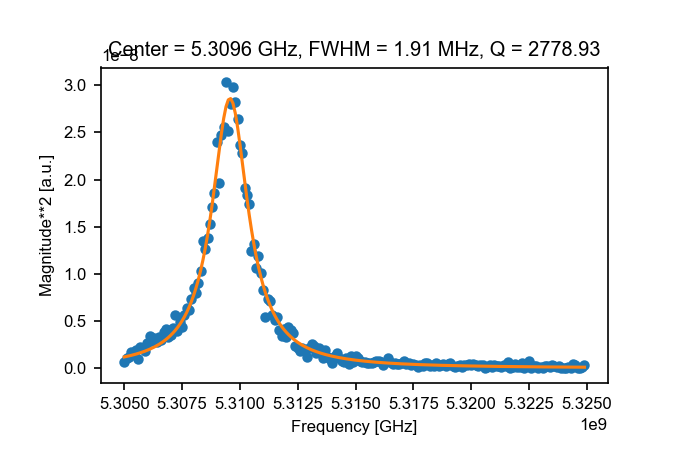

Text(0.5,1,'Center = 5.3096 GHz, FWHM = 1.91 MHz, Q = 2778.93')

In [12]:
station.hetsrc.RF.power(-70)
hetfreqs = np.arange(5.305e9, 5.325e9, 0.1e6)
station.TWPA.on()
ctl = ss.setup_soft_sweep(hetfreqs, station.hetsrc.frequency, integration_time=30e-3)
testout = get_resonator_spec_and_fit(hetfreqs)
station.TWPA.off()

plt.figure()
plt.plot(hetfreqs,testout[0]**2,'o')
plt.plot(hetfreqs,testout[2].best_fit)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Magnitude**2 [a.u.]')
plt.title('Center = %.4f GHz, FWHM = %.2f MHz, Q = %.2f' % (testout[2].params['center'].value*1e-9, 2*testout[2].params['sigma'].value*1e-6, testout[2].params['center'].value/(2*testout[2].params['sigma'].value)))

## Live-monitor of resonator spec

In [ ]:
fvals = np.linspace(5.29e9, 5.33e9, 51)
ctl = ss.setup_soft_sweep(fvals, station.hetsrc.frequency, integration_time=30e-3)

def monitor_resonator_spec(ax, fvals, data_line=None):
    mag, phase, fitout = get_resonator_spec_and_fit(fvals)
    
    if data_line is None:
        data_line = ax.plot(fvals, mag**2)[0]
    else:
        data_line.set_ydata(mag**2)
    
    ax.relim()
    ax.autoscale_view(True, True, True)
    ax.get_figure().canvas.draw()
    
    return data_line
    

fig, ax = plt.subplots(1,1)

data_line = None
ax.set_xlabel('Frequency')
ax.set_ylabel('Magnitude')

for i in range(10):
    data_line = monitor_resonator_spec(ax, fvals, data_line=data_line)

## Resonator spec vs power

In [ ]:
station = qcodes.Station.default #resonator spec vs power
spec_frequencies=np.linspace(5.3e9, 5.33e9, 61)
spec_src=station.hetsrc.frequency
spec_powers=np.linspace(-70,-30,5)

ctl = ss.setup_soft_time_avg_spec(spec_frequencies, spec_src)

station.TWPA.on()
so = sweep(station.hetsrc.RF.power,spec_powers)(
    ss.measure_soft_time_avg_spec(spec_frequencies, station.hetsrc, integration_time=10e-3, setup=True))

result = do_experiment(f'resonator_specvspower/{SAMPLE}', so, live_plot=True)
station.TWPA.off()

# TWPA tuning

In [121]:
station.TWPA.power(), station.TWPA.frequency()

(8.0, 7990000000.0)

In [ ]:
# station.hetsrc.RF.power(-60)
# so = sweep(station.TWPA.power, np.arange(9, 11, 0.1))(
#     softspec(np.linspace(5.3e9, 5.326e9, 27), station.hetsrc, navgs=10, setup_awg=False)
# )

# result = do_experiment(f'TWPA_resonator_spec/{SAMPLE}', so, live_plot=True)

In [ ]:
def get_snr_from_max(trace, background_range=(0, 30)):
    idx0, idx1 = background_range
    S = np.abs(trace).max()
    N = np.abs(np.std(trace[idx0:idx1]))
    return S, N

@getter(('SNR', ''))
def SNR():
    mag, phase = ss.get_soft_sweep_trace()
    trace = mag * np.exp(-1j*phase)
    s, n = get_snr_from_max(trace)
    return s/n

spec_frequencies = np.linspace(5.29e9, 5.33e9, 101)
spec_src = station.hetsrc
integration_time = 30e-3

pump_amps = np.linspace(8.0, 9.5, 16)
pump_frqs = np.linspace(7.99e9, 8.02e9, 31)

ctl = ss.setup_soft_sweep(spec_frequencies, spec_src.frequency, integration_time=integration_time)

station.TWPA.on()
so = sweep(station.TWPA.power, pump_amps)(
    sweep(station.TWPA.frequency, pump_frqs)(
#         measure_soft_time_avg_spec(spec_frequencies, spec_src, integration_time=integration_time, setup=False),
        measure(SNR),
    )
)

result = do_experiment(f'tune_TWPA_resonator_spec/{SAMPLE}', so, live_plot=True)
station.TWPA.off() #the TWPA power seems to warm up the fridge so let's turn it off when we are not measuring

d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:556: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


Starting experimental run with id: 94


In [ ]:
station.RF.power()

# Resonator vs Gate Response

## Measure at a single frequency

### Vs cutter

In [ ]:
# setup_single_averaged_IQpoint(0.1e-3, 10e-3, setup_awg=True)

# cur_cutter = dac_cutter()
# station.hetsrc.frequency(5.31347e9)
# station.TWPA.on() #we don't have a BNC T at the moment, we can remove this once we split the marker for the cavity
# so = sweep(dac_cutter, np.arange(cur_cutter, 1000, 1))(
#     measure(get_single_averaged_IQpoint_chanA),
# )

# result = do_experiment(f"resonator_gate_response/{SAMPLE}", so, live_plot=True)
# station.TWPA.off()

### Vs plungers

In [ ]:
# station.hetsrc.frequency(5.31347e9)
# cur_plunger = dac_leftplunger()

# so = sweep(set_plungers, np.arange(cur_plunger,-100.0,-0.5))(
#     measure(get_single_averaged_IQpoint_chanA),
# )

# station.TWPA.on()
# result = do_experiment(f"resonator_gate_response/{SAMPLE}", so, live_plot=True)
# station.TWPA.off()

In [ ]:
station.hetsrc.frequency(5.310e9)
station.hetsrc.RF.power(-70)

cur_cutter = dac_cutter()

so = measure_soft_gate_sweep(
    np.arange(cur_cutter, cur_cutter+5, 0.1), dac_cutter,
    integration_time=10e-3, setup=True,
)

station.TWPA.on()
result = do_experiment(f"soft_sweep_gate/{SAMPLE}", so, live_plot=True)
station.TWPA.off()

### Fixed frequency scans (view each point)

In [14]:
station.TWPA.frequency()

7990000000.0

In [ ]:
%%time
#Fixed frequency scan if you want to see each point individually

station.hetsrc.frequency(5.31347e9+4e6)
cur_plunger = dac_leftplunger()
cur_cutter = dac_cutter()
cutter_vals = np.arange(300,1500.,5)
plunger_vals = np.arange(-300,100.,10)


setup_single_averaged_IQpoint(0.1e-3, 30e-3, setup_awg=True)
so = sweep(dac_cutter, cutter_vals)(sweep(set_plungers, plunger_vals)(
    measure(get_single_averaged_IQpoint_chanA),
))

station.TWPA.on()
result = do_experiment(f"fixed_frequency/{SAMPLE}", so, live_plot=True)
station.TWPA.off()

### Fixed frequency scan (only see 1d, faster)

In [15]:
%%time
#Fast Fixed frequency scan if not seeing each 1d line is ok with you

station.hetsrc.frequency(5.310e9+4e6)
cur_plunger = dac_leftplunger()
cur_cutter = dac_cutter()
cutter_vals = np.arange(300,1500.,5)
plunger_vals = np.arange(-300,100.,10)


ss.setup_soft_sweep(plunger_vals, set_plungers, time_bin=0.2e-3, integration_time=30e-3, setup_awg=True, ctl=None)
so = sweep(dac_cutter, cutter_vals)(ss.measure_soft_gate_sweep(
    plunger_vals, set_plungers,
    integration_time=10e-3, setup=False,
)


station.TWPA.on()
result = do_experiment(f"fixed_frequency/{SAMPLE}", so, live_plot=True)
station.TWPA.off()

SyntaxError: invalid syntax (<unknown>, line 17)

## Take full resonator scan vs gate

### Vs cutter

In [ ]:
dac_leftplunger(-275);dac_rightplunger(-275)

In [ ]:
cur_cutter = dac_cutter()
station.hetsrc.RF.power(-70)
spec_frequencies=np.linspace(5.304e9, 5.313e9, 181)
spec_src=station.hetsrc

ctl = setup_soft_sweep(spec_frequencies, spec_src)

station.TWPA.on()
so = sweep(dac_cutter, np.arange(526, 532, 0.1))(
    measure_soft_time_avg_spec(spec_frequencies, spec_src, integration_time=30e-3)
)

result = do_experiment(f"resonator_gate_response/{SAMPLE}", so, live_plot=True)
station.TWPA.off()

### Vs plungers

In [ ]:
cur_plunger = dac_leftplunger()
station.hetsrc.RF.power(-70)
spec_frequencies=np.linspace(5.305e9, 5.32e9, 151)
spec_src=station.hetsrc

ctl = ss.setup_soft_time_avg_spec(spec_frequencies, spec_src)

station.TWPA.on()
so = sweep(set_plungers, np.arange(cur_plunger,-250.0,-1))(
    ss.measure_soft_time_avg_spec(spec_frequencies, spec_src)
)

result = do_experiment(f"resonator_gate_response/{SAMPLE}", so, live_plot=True)
station.TWPA.off()

# Qubit spec

## Spec vs power

In [ ]:
station = qcodes.Station.default #spec at one power
station.hetsrc.RF.power(-70)
station.hetsrc.frequency(5.310e9)
station.qubsrc.power(-20)
qubit_frequencies = np.arange(6e9, 8.5e9, 2e6)
spec_src=station.qubsrc

ctl = setup_soft_sweep(qubit_frequencies, spec_src.frequency)

station.TWPA.on()
spec_src.output_rf('ON')
so = ss.measure_soft_time_avg_spec(qubit_frequencies, spec_src, integration_time=30e-3, setup=True)

result = do_experiment(f'qubit_spec/{SAMPLE}', so, live_plot=True)
station.TWPA.off()

In [ ]:
station = qcodes.Station.default ##spec vs power
station.hetsrc.RF.power(-70)
station.hetsrc.frequency(5.306e9)
station.qubsrc.power(-15)
qubit_frequencies = np.arange(6e9, 6.5e9, 4e6)
qubit_powers = np.linspace(-30,-10,6)
spec_src=station.qubsrc

ctl = ss.setup_soft_sweep(qubit_frequencies, spec_src.frequency)

station.TWPA.on()
spec_src.output_rf('ON')
so = sweep(station.qubsrc.power,qubit_powers)(
    measure_soft_time_avg_spec(qubit_frequencies, spec_src, integration_time=30e-3))

result = do_experiment(f'qubit_spec_vs_power/{SAMPLE}', so, live_plot=True)
station.TWPA.off()

## Spec vs gates

### Coarse scans (requiring resonator frequency change)

In [ ]:
station = qcodes.Station.default
station.hetsrc.RF.power(-70)
station.qubsrc.power(-20)
het_freqs = np.arange(5.304e9,5.313e9,1e6)
qub_freqs = np.arange(6.4e9, 8.5e9, 4e6)
cur_cutter = dac_cutter()
cutter_voltages = np.arange(cur_cutter, cur_cutter+2, 0.4)

ctl = ss.setup_soft_sweep(het_freqs, station.hetsrc.frequency, integration_time=30e-3)
so = sweep(dac_cutter, cutter_voltages)(
    ss.measure_qubit_spec_optimize_resonator(het_freqs, station.hetsrc, 
                                           qub_freqs, station.qubsrc, integration_time=30e-3)) 

#note that the two integration times must match!!

result = do_experiment(f'test_optimizedqubit_spec/{SAMPLE}', so, live_plot=True)

### Fine scans (resonator does not change)

In [ ]:
station = qcodes.Station.default ##spec vs cutter
station.hetsrc.RF.power(-70)
station.hetsrc.frequency(5.3088e9)
station.qubsrc.power(-20)
qubit_frequencies = np.arange(6.4e9, 7.8e9, 4e6)
cur_plunger = dac_leftplunger_fine()
plunger_voltages = np.arange(cur_plunger, cur_plunger+2, 0.4)
spec_src=station.qubsrc

ctl = setup_soft_sweep(qubit_frequencies, spec_src.frequency)

station.TWPA.on()
spec_src.output_rf('ON')
so = sweep(dac_leftplunger_fine, plunger_voltages)(
    measure_soft_time_avg_spec(qubit_frequencies, spec_src, integration_time=30e-3, setup=True))

result = do_experiment(f'charge_dispersions/{SAMPLE}', so, live_plot=True)
station.TWPA.off()

# Magnetic Field Sweeps

## TESTING UNDER DEVELOPMENT DO NOT USE UNLESS YOU ARE SURE

In [ ]:
station.mgnt.theta_target(0.0)
station.mgnt.phi_target(0)

In [115]:
print('Measured field = ' + station.mgnt.field_measured().repr_spherical())
#print('Measured field = ' + station.mgnt.field_measured().repr_cartesian())
print('Target field = ' + station.mgnt.field_target().repr_spherical())
#print('Target field = ' + station.mgnt.field_target().repr_cartesian())

Measured field = FieldVector(r=0.30063101969025086, phi=174.68545433005525, theta=0.8230821778707806)
Target field = FieldVector(r=0.3006183994131641, phi=174.4278021960362, theta=0.8307338088888135)


### Get resonator trace and plot

In [28]:
from functools import partial
from qcodes.math.field_vector import FieldVector

def get_resonator_freq(): #helper function to pass variables into resonator spec
    global xvals
    return get_resonator_spec_and_fit(xvals)

def get_resonator_FWHM(): #helper function to pass variables into resonator spec
    global xvals
    _,_,fitout=get_resonator_spec_and_fit(xvals)
    return 2*fitout.params['sigma'].value

def measure_and_plot_resonator(ax, line): #plots the trace
    liney, phasey, fitout = get_resonator_freq()
    time.sleep(0.5)
    
    line.set_ydata(liney)
    ax.relim()
    ax.autoscale_view(True, True, True)
    ax.get_figure().canvas.draw()
    
    return fitout.params['center'].value
    



#ctl = ss.setup_soft_sweep(het_freqs, station.hetsrc.frequency, integration_time=30e-3)
#testout = get_resonator_spec_and_fit(het_freqs)
#testout.params['center'].value, testout.params['center'].stderr


## Manual Magnet Sweeps

In [106]:
station.mgnt.r_measured()

0.25102758812528952

In [72]:
station.mgnt.field_ramp_rate(FieldVector(x=1e-3, y=1e-3, z=1e-3)) ##sweep r


cur_r = station.mgnt.r_measured()
station.hetsrc.RF.power(-70)
spec_frequencies=np.arange(5.295e9, 5.315e9, 0.5e6)
spec_src=station.hetsrc

ctl = ss.setup_soft_sweep(spec_frequencies, spec_src)

station.TWPA.on()
so = sweep(set_magnet_r, np.arange(cur_r,100e-3, 2e-3))(
    ss.measure_soft_time_avg_spec(spec_frequencies, spec_src, integration_time=30e-3)
)

result = do_experiment(f"resonator_magnet_r/{SAMPLE}", so, live_plot=True)
station.TWPA.off()



d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:556: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


Starting experimental run with id: 82


KeyboardInterrupt: 

In [102]:
station.mgnt.theta_target()

0.83247971950109745

In [105]:
cur_theta = station.mgnt.theta_target() ##sweep theta
station.hetsrc.RF.power(-70)
spec_frequencies=np.arange(5.295e9, 5.315e9, 0.5e6)
spec_src=station.hetsrc

ctl = ss.setup_soft_sweep(spec_frequencies, spec_src)

station.TWPA.on()
so = sweep(set_magnet_theta, np.arange(cur_theta,cur_theta-0.1, -0.005))(
    ss.measure_soft_time_avg_spec(spec_frequencies, spec_src, integration_time=30e-3)
)

result = do_experiment(f"resonator_magnet_theta/{SAMPLE}", so, live_plot=True)
station.TWPA.off()



d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:556: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


Starting experimental run with id: 89


KeyboardInterrupt: 

In [52]:
station.mgnt.phi_measured() 

0.0

In [79]:
cur_phi = station.mgnt.phi_target() ##sweep phi
station.hetsrc.RF.power(-70)
spec_frequencies=np.arange(5.295e9, 5.315e9, 0.5e6)
spec_src=station.hetsrc

ctl = ss.setup_soft_sweep(spec_frequencies, spec_src)

station.TWPA.on()
so = sweep(set_magnet_phi, np.arange(cur_phi,cur_phi-15.0, -1))(
    ss.measure_soft_time_avg_spec(spec_frequencies, spec_src, integration_time=30e-3)
)

result = do_experiment(f"resonator_magnet_phi/{SAMPLE}", so, live_plot=True)
station.TWPA.off()



d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:556: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


Starting experimental run with id: 84
Timeout during sending!


KeyboardInterrupt: 

## Automated Magnet Sweeps

<IPython.core.display.Javascript object>


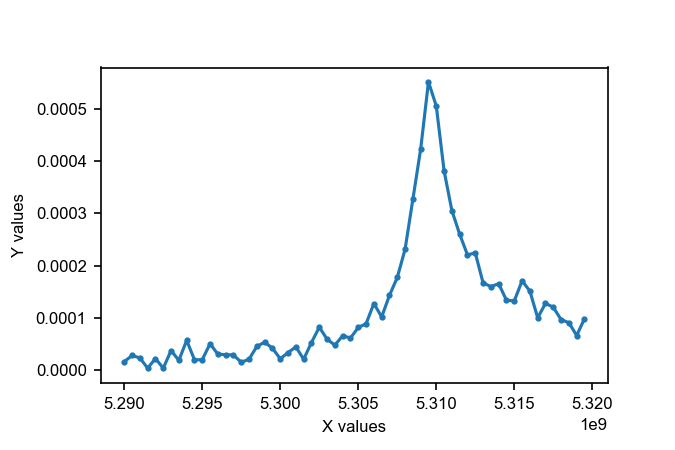

d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:556: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


Evaluating at phi = 161.74488129694222, theta = 0.86032228975405
Setting field target to FieldVector(r=0.06801599427465016, phi=163.8169101867406, theta=0.9268993944658673)
Setting field target to FieldVector(r=0.06805578805091402, phi=162.81939160321463, theta=0.8930242219754676)
Setting field target to FieldVector(r=0.06802895162468876, phi=161.74488129694222, theta=0.8603222897542101)
Move complete. (r, phi, theta) = (0.06810800246667054, 163.3007557660064, 0.8783239964423757)
Evaluating at phi = 167.74488129694222, theta = 0.86032228975405
Setting field target to FieldVector(r=0.0680149820310906, phi=164.7602761907188, theta=0.8726038625451396)
Setting field target to FieldVector(r=0.0680552906889043, phi=166.2421541932618, theta=0.8657443976365172)
Setting field target to FieldVector(r=0.06802895162468876, phi=167.74488129694222, theta=0.8603222897542101)
Move complete. (r, phi, theta) = (0.0680076466288902, 168.6900675259798, 0.8592070521786155)
Evaluating at phi = 167.7448812969

<IPython.core.display.Javascript object>


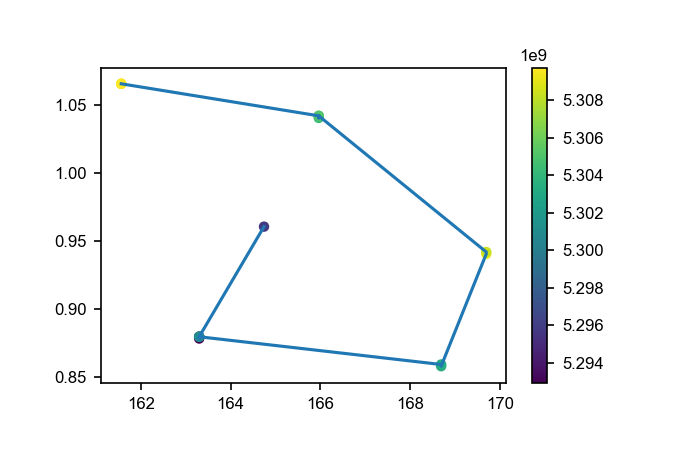

In [87]:
from pytopo.field_optimization.movement import FieldOptimizationProblem ##optimize at fixed mag


xvals = np.arange(5.29e9,5.32e9,0.5e6)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('X values')
ax.set_ylabel('Y values')
line = ax.plot(xvals, np.zeros_like(xvals), '.-')[0]

ctl = ss.setup_soft_sweep(xvals, station.hetsrc.frequency, integration_time=30e-3)

# now we wrap the measure function such that it doesn't need arguments anymore
# of course this requires that we have already good constant values for ax and line
measure_trace = partial(measure_and_plot_resonator, ax, line)

# now we just have to call the new function wrapper without arguments


field_opt = FieldOptimizationProblem(station.mgnt, measure_trace, get_resonator_FWHM)



cur_r = station.mgnt.r_target()
cur_theta = station.mgnt.theta_target()
cur_phi = station.mgnt.phi_target()

with station.TWPA():
    opt, extra = field_opt.optimize_at_fixed_magnitude(
        cur_r, (cur_phi-3, cur_phi+3), 2,(cur_theta-0.1, cur_theta+0.1), 2,
        plot=True, return_extra=True, verbose=True, ramp_rate=1e-3, n_steps=3
    )
# station.TWPA.off()

In [112]:
0.15/10/10

0.0015

<IPython.core.display.Javascript object>


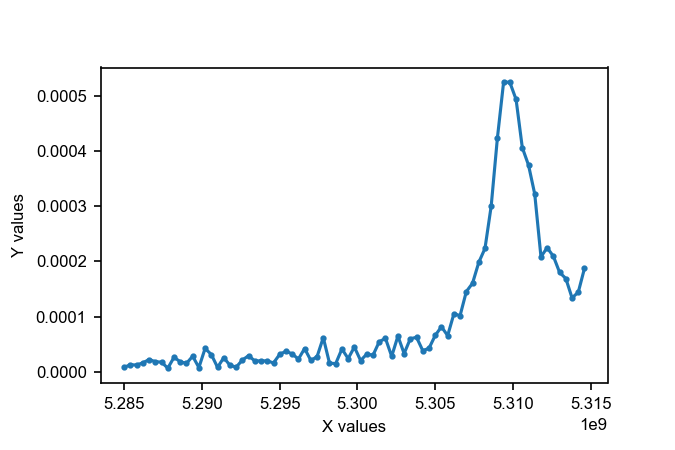

d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:556: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


Moving to initial field vector...
Step threshold met, stopping move early.
Move complete.
Optimizing at |B| = 0.2509275991197461...
Step threshold met, stopping move early.
Move complete.
Evaluating at phi = 173.8298249049704, theta = 0.8497966421006405
Step threshold met, stopping move early.
Move complete.
Evaluating at phi = 173.8298249049704, theta = 0.8522966421006407
Move complete. (r, phi, theta) = (0.2509275991197461, 173.8298249049704, 0.8497966421006405)
Evaluating at phi = 173.8298249049704, theta = 0.8472966421006405
Move complete. (r, phi, theta) = (0.2509275991197461, 173.8298249049704, 0.8497966421006405)
Evaluating at phi = 173.8298249049704, theta = 0.8547966421006405
Move complete. (r, phi, theta) = (0.2509275991197461, 173.8298249049704, 0.8497966421006405)
Evaluating at phi = 173.8298249049704, theta = 0.8447966421006405
Move complete. (r, phi, theta) = (0.2509275991197461, 173.8298249049704, 0.8497966421006405)
Found optimum for |B| = 0.2509275991197461 at (173.829

KeyboardInterrupt: 

In [114]:
xvals = np.arange(5.285e9,5.315e9,0.4e6)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('X values')
ax.set_ylabel('Y values')
line = ax.plot(xvals, np.zeros_like(xvals), '.-')[0]

ctl = ss.setup_soft_sweep(xvals, station.hetsrc.frequency, integration_time=30e-3)

# now we wrap the measure function such that it doesn't need arguments anymore
# of course this requires that we have already good constant values for ax and line
measure_trace = partial(measure_and_plot_resonator, ax, line)

# now we just have to call the new function wrapper without arguments


field_opt = FieldOptimizationProblem(station.mgnt, measure_trace, get_resonator_FWHM)



cur_r = station.mgnt.r_measured()
cur_theta = station.mgnt.theta_measured()
cur_phi = station.mgnt.phi_measured()
0.005

with station.TWPA():
    optimum, extra = field_opt.optimize_and_ramp_magnitude(
        cur_r, 0.4, 10,
        cur_phi, 0, 1,
        cur_theta, 0.01, 5,
        reoptimization_threshold=4.,
        ramp_rate=3e-3,
        n_steps=1,
        return_extra=True
    )

# station.TWPA.off()

<IPython.core.display.Javascript object>


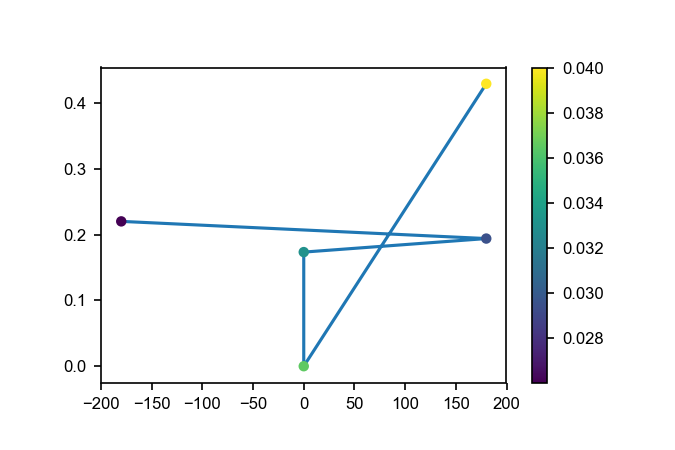

In [28]:
plt.figure()
plt.plot(
    [field.phi for field in extra['history']['optima']],
    [field.theta for field in extra['history']['optima']],
    zorder=-10
)
plt.scatter(
    [field.phi for field in extra['history']['optima']],
    [field.theta for field in extra['history']['optima']],
    c=[field.r for field in extra['history']['optima']]
)
plt.colorbar()

<IPython.core.display.Javascript object>


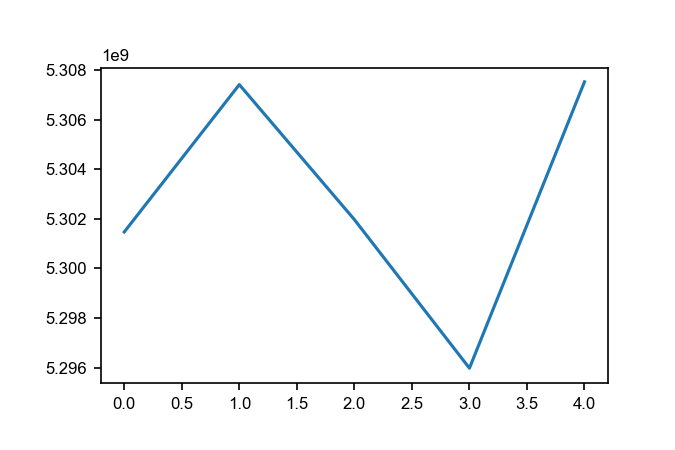

In [33]:
plt.figure()
plt.plot(extra['history']['objectives'])

# OLD STUFF BELOW - ONLY REFERENCE

In [ ]:
frqs, data = soft_resonator_spec(5.6e9, 5.7e9, 1e6, RF_power=-70)

## Resonator vs time

In [ ]:
start, stop, step = 5.6e9, 5.7e9, 2e6
integration_time = 10e-3
trigger_interval = 1e-3

exp = new_experiment(name='resonator_spec_vs_time', sample_name=qc.config.user.experiment.sample_name)

# set basic RF stuff
station.hetsrc.RF.power(-70)

ctl = station.post_iq_acq
ctl.average_buffers(True)
ctl.demod_frq(station.hetsrc.IF())

SR = station.alazar.sample_rate()
t_buf = trigger_interval - 10e-6
nbufs = int(integration_time // trigger_interval)

acq_size = 2 * integration_time * SR * 1e-6 # in MB
buf_size = 2 * t_buf * SR * 1e-6
print(f'acquisition size: {acq_size} MB; {buf_size} MB/buffer.')  
print(f'acquisition time/buffer: {t_buf*1e6} us; {nbufs} buffers.')

ctl.setup_acquisition(
    samples=int(t_buf * SR // 64 * 64),
    records=1,
    buffers=nbufs,
    allocated_buffers=10,
)

tvals = np.arange(100)
frqs = np.arange(start, stop+step, step)
data = np.zeros((frqs.size, 2), dtype=np.complex64)

m = acquisition_tools.AlazarMeasurement(
    station=station, exp=exp, 
    soft_params=['iteration', station.hetsrc.frequency],
    hard_axes=[
        ('channel', np.array([1,2])),
    ],
    imag=False, real=False, mag=True, phase=True,
)

with m.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for j, it in enumerate(tvals):
        for i, f in enumerate(frqs):
            print(f'Current iteration: {it}. Current frequency: {f*1e-6:.2f} MHz', end='\r')
            station.hetsrc.frequency(f)
            time.sleep(0.01)

            _data = ctl.acquisition()[0,0,0,:]
            data[i,:] = _data
            mag, phase = np.abs(_data), np.angle(_data, deg=True)

            result = m.get_result(_data, (station.hetsrc.frequency, f), ('iteration', it))
            datasaver.add_result(*result)

# Gate response

In [ ]:
station.hetsrc.frequency(5.647e9)
station.hetsrc.RF.power(-70)
SR = station.alazar.sample_rate()
dac = station.ivvi.dac1
dacl = station.ivvi.dac11
dacr = station.ivvi.dac13

station = qc.Station.default
exp = new_experiment(name='gate_response', sample_name=qc.config.user.experiment.sample_name)

ctl = station.post_iq_acq
ctl.average_buffers(True)
ctl.demod_frq(station.hetsrc.IF())

ctl.setup_acquisition(
        samples=int(980e-6 * SR // 64 * 64),
        records=1,
        buffers=10,
        allocated_buffers=10,
    )

gatevals = np.arange(0, 1000, 0.5)

m = acquisition_tools.AlazarMeasurement(
        station=station, exp=exp, 
        soft_params=[dacl],
        hard_axes=[
            ('channel', np.array([1,2])),
        ],
        imag=False, real=False, mag=True, phase=True,
    )

with m.run() as datasaver:
        
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for i, g in enumerate(gatevals):
        print(f'Current gate voltage: {g} mV', end='\r')
        dacl(int(g))
        dacr(int(g))
        dac(int(g))

        _data = ctl.acquisition()[0,0,0,:]
        mag, phase = np.abs(_data), np.angle(_data, deg=True)

        result = m.get_result(_data, (dacl, g))
        datasaver.add_result(*result)

# Qubit spec

# Scribble

In [ ]:
f"{123456:1.3e}"